# Krypton Corrections

## Correct energy using Kr maps and obtain resolution

### Author: JJGC

In [1]:
import time
print("Last updated on ", time.asctime())

Last updated on  Wed Aug 22 20:35:13 2018


### Input files

In [105]:
input_path  = f"$IC_DATA/dst"
output_path = f"$IC_DATA/ldst"
map_path    = f"$IC_DATA/maps"

input_file_names  = ['dst_6206_0000_9999.h5','dst_6206_10000_19999.h5',
                    'dst_6206_20000_29999.h5','dst_6206_30000_39299.h5']
output_file_name  = 'ldst_6206.h5'
map_file_name     = 'kr_maps_6206.h5'
emap_file_name    = 'kr_emap_6206.h5'
bootstrap_correction_filename   = f"$IC_DATA/maps/kr_corrections_run6206.h5"

### Notebook configuration

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection

plt.rcParams["figure.figsize"] = 8, 6
plt.rcParams["font.size"     ] = 14

In [4]:
import os
import time
import datetime 
import numpy as np
import pandas as pd
import matplotlib
import tables            as tb
import random
import glob
import warnings

In [309]:
from  invisible_cities.io.dst_io              import load_dsts
from  invisible_cities.core .core_functions   import in_range
from  invisible_cities.core.system_of_units_c import units
import invisible_cities.reco.corrections      as corrf

In [103]:
from krcal.core.io_functions       import kdst_write
from krcal.core.histo_functions    import h1, h1d, h2, h2d, plot_histo
from krcal.core.io_functions       import filenames_from_list
from krcal.core.io_functions       import write_maps
from krcal.core.io_functions       import read_maps
from krcal.core.io_functions       import write_energy_map
from krcal.core.io_functions       import read_energy_map

In [7]:
from krcal.core.core_functions          import time_delta_from_time
from krcal.core.core_functions          import phirad_to_deg

In [80]:
from krcal.core.analysis_functions      import kr_ranges_and_bins
from krcal.core.analysis_functions      import fiducial_volumes
from krcal.core.analysis_functions      import fid_eff
from krcal.core.analysis_functions      import select_rphi_sectors
from krcal.core.analysis_functions      import plot_sector
from krcal.core.analysis_functions      import plot_sectors
from krcal.core.analysis_functions      import events_sector
from krcal.core.analysis_functions      import event_map
from krcal.core.analysis_functions      import kr_event_selection
from krcal.core.analysis_functions      import kr_event

In [9]:
from krcal.core.fit_lt_functions        import fit_lifetime
from krcal.core.fit_lt_functions        import plot_fit_lifetime_and_chi2
from krcal.core.fit_lt_functions        import print_fit_lifetime
from krcal.core.fit_lt_functions        import time_fcs
from krcal.core.fit_lt_functions        import fit_fcs_in_sectors
from krcal.core.fit_lt_functions        import fit_map

In [399]:
from krcal.core.fit_energy_functions    import fit_energy
from krcal.core.fit_energy_functions    import plot_fit_energy
from krcal.core.fit_energy_functions    import print_fit_energy
from krcal.core.fit_energy_functions    import energy_map
from krcal.core.fit_energy_functions    import resolution_r_z
from krcal.core.fit_energy_functions    import plot_resolution_r_z

In [11]:
from krcal.core.fit_lt_histograms          import histo_fit_sectors
from krcal.core.fit_lt_histograms          import print_fit_sectors_pars
from krcal.core.fit_lt_histograms          import plot_fit_sectors

In [12]:
from krcal.core.kr_types import PlotLabels, KrEvent
from krcal.core.kr_types import FitType, KrSector, MapType
from krcal.core          import fit_functions_ic as fitf

In [125]:
from krcal.core.map_functions   import draw_wedges
from krcal.core.map_functions   import define_rphi_sectors
from krcal.core.map_functions   import rphi_sector_map2
from krcal.core.map_functions   import rphi_sector_map
from krcal.core.map_functions   import tsmap_from_fmap
from krcal.core.map_functions   import amap_from_tsmap
from krcal.core.map_functions   import relative_errors
from krcal.core.map_functions   import draw_maps
from krcal.core.map_functions   import draw_energy_map


In [50]:
from krcal.core.s1s2_functions  import energy_time_profile
from krcal.core.s1s2_functions  import energy_X_profile

In [14]:
from krcal.core.correction_functions import e0_correction
from krcal.core.correction_functions import lt_correction

In [15]:
import krcal.dev.corrections       as corrections 


In [16]:
from numpy import pi

In [17]:
from typing      import List, Tuple, Dict, Sequence, Iterable

In [18]:
from ipywidgets import interact, interactive, fixed
from IPython.display import display

### Input/output 

In [112]:
filenames =filenames_from_list(input_file_names,
                               output_file_name,
                               map_file_name,
                               emap_file_name,
                               input_path,
                               output_path,
                               map_path)
input_dst_filenames, output_dst_filename, map_filename, emap_filename = filenames

In [113]:
print(f'input dsts:\n first = {input_dst_filenames[0]}\n last = {input_dst_filenames[-1]}')
print(f"output dst = {output_dst_filename}")
print(f"map file   = {map_filename}")
print(f"emap file   = {emap_filename}")

input dsts:
 first = /Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6206_0000_9999.h5
 last = /Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6206_30000_39299.h5
output dst = /Users/jjgomezcadenas/Projects/ICDATA/ldst/ldst_6206.h5
map file   = /Users/jjgomezcadenas/Projects/ICDATA/maps/kr_maps_6206.h5
emap file   = /Users/jjgomezcadenas/Projects/ICDATA/maps/kr_emap_6206.h5


In [21]:
dst           = load_dsts(input_dst_filenames, "DST", "Events")

In [22]:
unique_events = ~dst.event.duplicated()
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of events: {number_of_evts_full}")

Total number of events: 4085430


In [23]:
dst.columns

Index(['index', 'event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w',
       'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

### Select in R

In [24]:
Rmax = 180

In [25]:
dstf = dst[dst.R<Rmax]

In [26]:
dst = dstf

### Time differences in seconds

In [27]:
dst_time = dst.sort_values('event')
T       = dst_time.time.values
DT      = time_delta_from_time(T)

### Ranges and binning

In [28]:
s1e_range = (2, 30)
s2e_range = (2000, 14000)
s2q_range = (200, 800)
xy_range  = (-220,  220)
z_range   = (10,  550)
krTimes, krRanges, krNbins, krBins = kr_ranges_and_bins(dst,
                                                        xxrange   = xy_range,
                                                        yrange    = xy_range,
                                                        zrange    = z_range,
                                                        s2erange  = s2e_range,
                                                        s1erange  = s1e_range,
                                                        s2qrange  = s2q_range,
                                                        xnbins    = 100,
                                                        ynbins    = 100,
                                                        znbins    = 50,
                                                        s2enbins  = 50,
                                                        s1enbins  = 10,
                                                        s2qnbins  = 25,
                                                        tpsamples = 3600) # tsamples in seconds

### Raw S2 energy vs Z

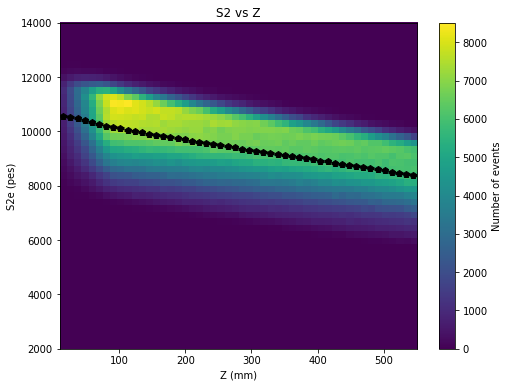

In [348]:
nevt = h2d(dst.Z, dst.S2e, krNbins.Z, krNbins.S2e, krRanges.Z, krRanges.S2e, 
           pltLabels=PlotLabels(x='Z (mm)', y='S2e (pes)', title='S2 vs Z'),
           profile=True,
           figsize=(8,6))

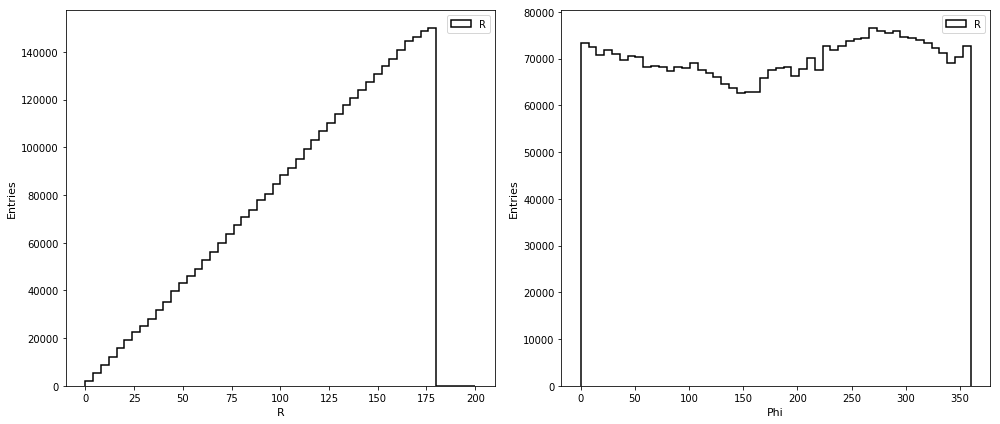

In [30]:
fig = plt.figure(figsize=(14,6))
ax      = fig.add_subplot(1, 2, 1)
(_)    = h1(dst.R, bins=50, range = (0,200), color='black', stats=False, lbl='R')
plot_histo(PlotLabels('R','Entries',''), ax)
ax      = fig.add_subplot(1, 2, 2)
(_)    = h1(phirad_to_deg(dst.Phi), bins=50, range = (0,360), color='black', stats=False, lbl='R')
plot_histo(PlotLabels('Phi','Entries',''), ax)
plt.tight_layout()

### Define factors fr and fphi

In [31]:
ns = 10 # number of radial sectors used to compute lifetime map
nw = 24 # number of phi sectors used to compute liefetime map

fr = Rmax / ns
fphi = 360 / nw
print(f'fr = {fr}, fphi = {fphi}')

fr = 18.0, fphi = 15.0


### Plot "quantified" R and Phi

In [32]:
R = (dst.R.values / fr).astype(int)
Phi = (phirad_to_deg(dst.Phi.values) / fphi).astype(int)

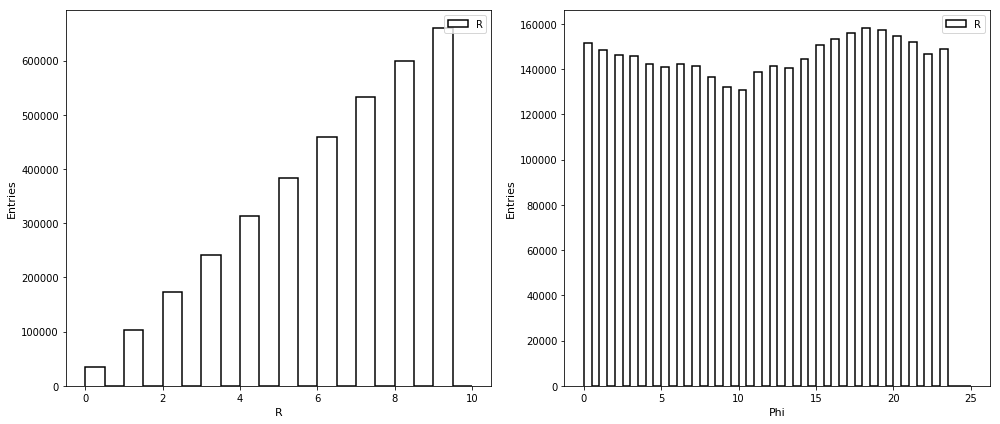

In [33]:
fig = plt.figure(figsize=(14,6))
ax      = fig.add_subplot(1, 2, 1)
(_)    = h1(R, bins=20, range = (0,10), color='black', stats=False, lbl='R')
plot_histo(PlotLabels('R','Entries',''), ax)
ax      = fig.add_subplot(1, 2, 2)
(_)    = h1(Phi, bins=50, range = (0,25), color='black', stats=False, lbl='R')
plot_histo(PlotLabels('Phi','Entries',''), ax)
plt.tight_layout()

### Load maps

In [34]:
me0df, me0udf, mltdf, mltudf = read_maps(filename=map_filename)
mu = (me0df.mean()).mean()
mx = (me0df.max()).max()

### E0 (geometry) correction

In [35]:
t0 = time.time()
E0 = e0_correction(dst.S2e.values, 
                  dst.R.values, 
                  dst.Phi.values, 
                  CE = me0df / mx,  # normalize to max E0
                  fr = fr, 
                  fphi = fphi)
t1 = time.time()
print(f' e0 correction: t = {t1 -t0}')

 e0 correction: t = 29.728549003601074


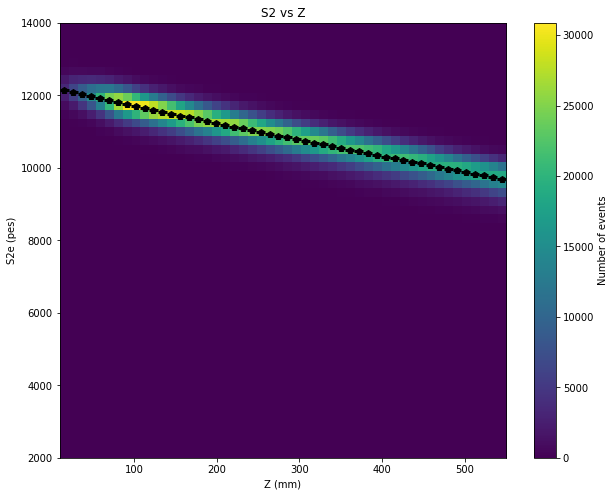

In [36]:
nevt = h2d(dst.Z, E0, krNbins.Z, krNbins.S2e, krRanges.Z, krRanges.S2e, 
           pltLabels=PlotLabels(x='Z (mm)', y='S2e (pes)', title='S2 vs Z'),
           profile=True,
           figsize=(10,8))

In [37]:
t0 = time.time()
E = lt_correction(E0, 
                  dst.R.values, 
                  dst.Phi.values,
                  dst.Z.values, 
                  CLT = mltdf,
                  fr = fr, 
                  fphi = fphi)
t1 = time.time()
print(f' LT correction: t = {t1 -t0}')

 LT correction: t = 29.855062007904053


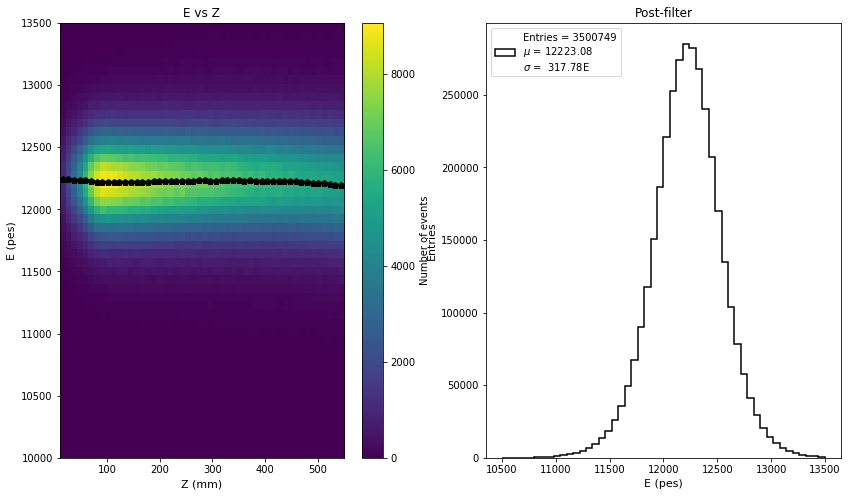

In [38]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

nevt = h2(dst.Z, E, krNbins.Z, krNbins.S2e, krRanges.Z, (10000, 13500), profile=True)
plot_histo(PlotLabels(x='Z (mm)', y='E (pes)', title='E vs Z'), ax, legend=False)

ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(E,  bins = 50, range =(10500,13500), stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','Post-filter'), ax, legendloc='upper left')

In [39]:
fc = fit_energy(E, nbins=50, range=(11000, 13000))

  Fit was valid = True
 Emu       = 12224.112702602048 +-0.16758879731265489 
 E sigma   = 302.1545132928437 +-0.13642593023542318 
 chi2    = 16.041695279016537 
 sigma E/E (FWHM)     (%) =5.808708766952364
 sigma E/E (FWHM) Qbb (%) =0.7502061010848815 


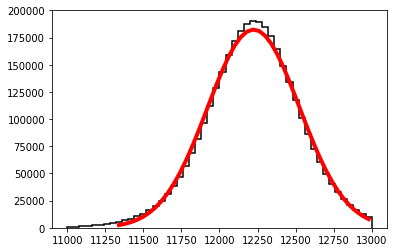

In [40]:
plot_fit_energy(fc)
print_fit_energy(fc)

In [41]:
kge = kr_event(dst, DT, E, E)

### Time dependence before/after correction

#### Before

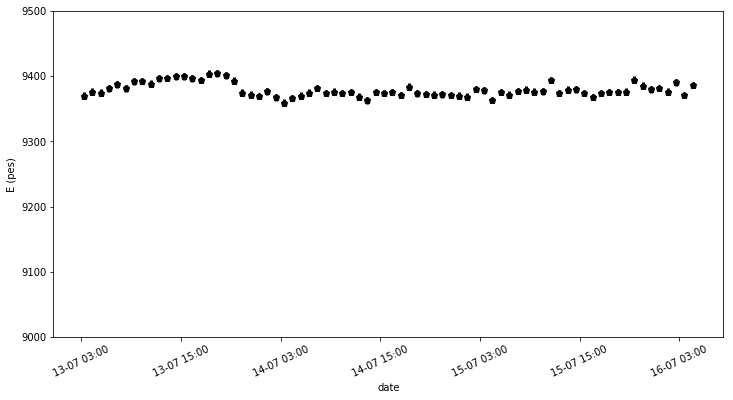

In [283]:
energy_time_profile(kge.T, kge.S2e, krNbins.T, krRanges.T, krTimes.timeStamps, 
                    erange=(9000, 9500),  
                    figsize=(12,6))

#### After

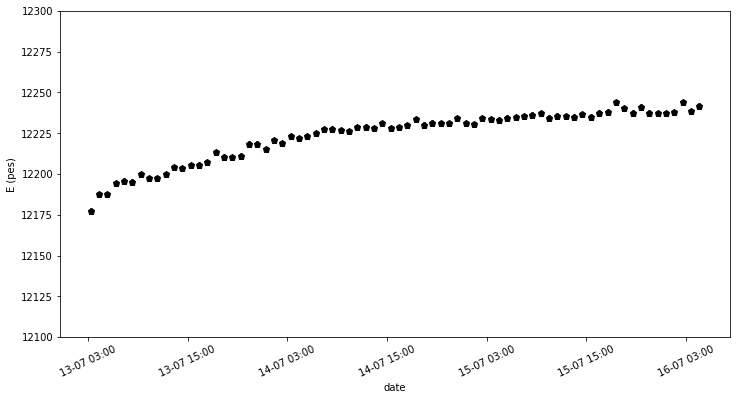

In [49]:
energy_time_profile(kge.T, kge.E, krNbins.T, krRanges.T, krTimes.timeStamps, 
                    erange=(12100, 12300),  
                    figsize=(12,6))

### Radial dependence

#### Before

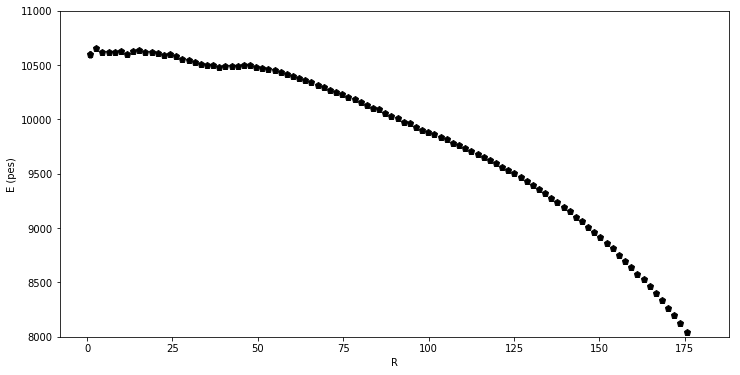

In [56]:
energy_X_profile(kge.R, kge.S2e, xnbins = 100, xrange=(0,180), xlabel = 'R',
                 erange=(8000, 11000),  
                 figsize=(12,6))

#### After: Further corrections needed!

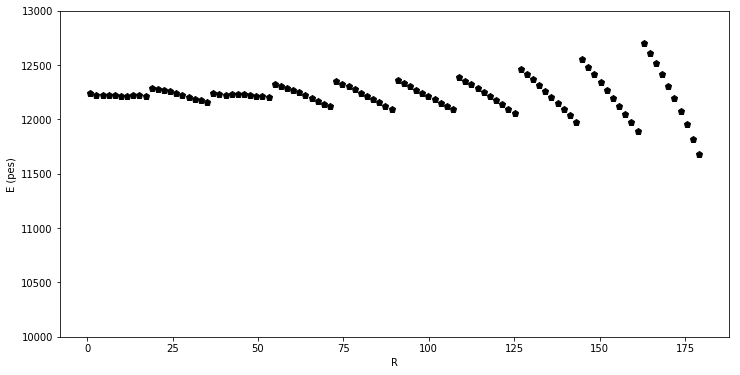

In [54]:
energy_X_profile(kge.R, kge.E, xnbins = 100, xrange=(0,180), xlabel = 'R',
                 erange=(10000, 13000),  
                 figsize=(12,6))

### Phi distribution

#### Before

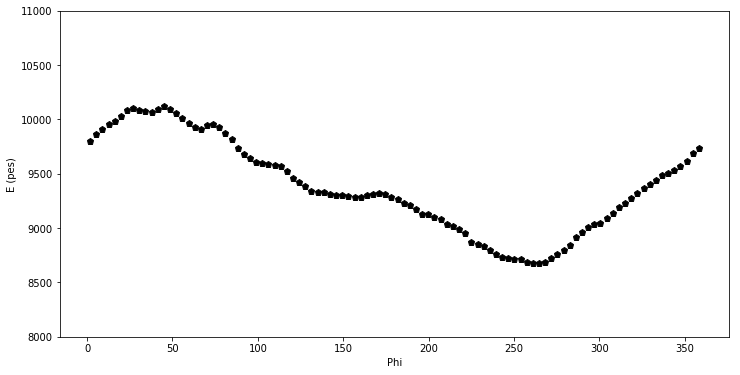

In [57]:
energy_X_profile(phirad_to_deg(kge.Phi), kge.S2e, xnbins = 100, xrange=(0,360), 
                 xlabel = 'Phi',
                 erange=(8000, 11000),  
                 figsize=(12,6))

#### After! Further correction needed.

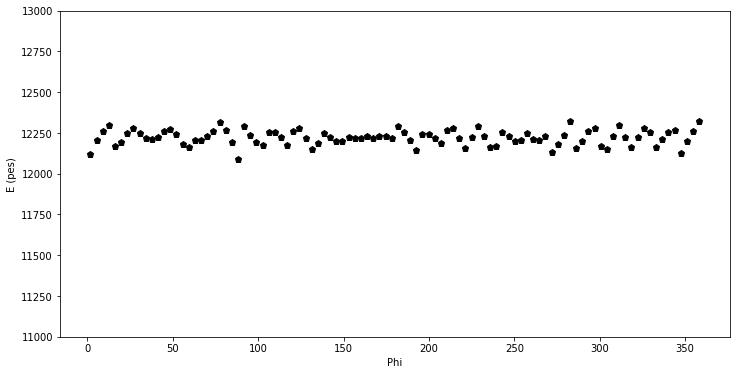

In [60]:
energy_X_profile(phirad_to_deg(kge.Phi), kge.E, xnbins = 100, xrange=(0,360), 
                 xlabel = 'Phi',
                 erange=(11000, 13000),  
                 figsize=(12,6))

### Dependence with Z

#### Before: shows the effect of lifetime

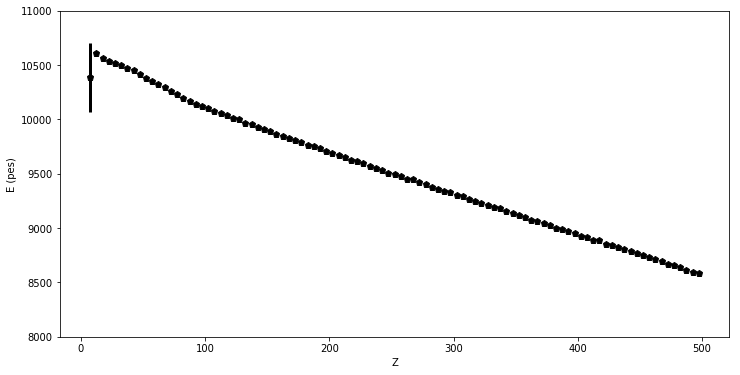

In [61]:
energy_X_profile(kge.Z, kge.S2e, xnbins = 100, xrange=(0,500), xlabel = 'Z',
                 erange=(8000, 11000),  
                 figsize=(12,6))

#### After: Lifetime corrected

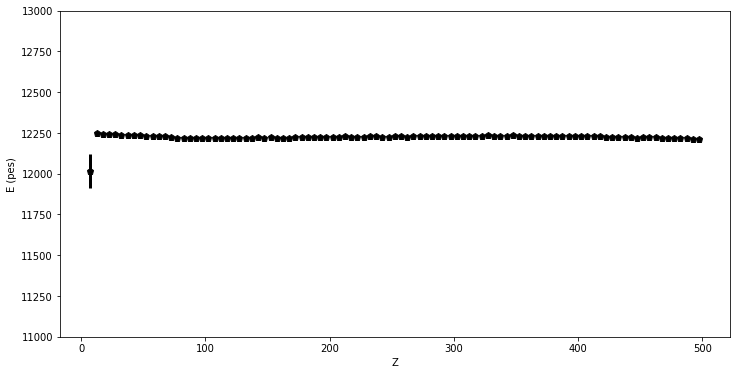

In [62]:
energy_X_profile(kge.Z, kge.E, xnbins = 100, xrange=(0,500), xlabel = 'Z',
                 erange=(11000, 13000),   
                 figsize=(12,6))

## Further geometrical correction is needed. This is done defining a fine-grained map for energy

In [358]:
360 / 3

120.0

In [359]:
R, PHI = rphi_sector_map(nSectors=50, rmax=180, sphi=3)
#print(f'sectors on R   = {R}')
#print(f'sectors on PHI = {PHI}')

In [360]:
W = define_rphi_sectors(R, PHI, verbose=False)

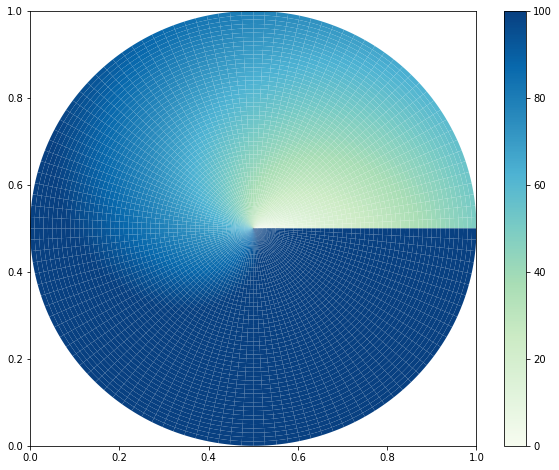

In [361]:
draw_wedges(W, cmap = matplotlib.cm.GnBu, rmax = 180, 
            scale= 0.5, figsize=(10,8), alpha=1.0,
            cr =range(50))

In [362]:
t0 = time.time()
KRES = select_rphi_sectors(dst, DT, E, E, W, verbose = False)
t1 = time.time()
print(f' KRES: t = {t1 -t0}')

 KRES: t = 358.1138987541199


In [363]:
nMap = event_map(KRES)

In [364]:
nS = events_sector(nMap)

In [365]:
nS

array([  12.19166667,   35.88333333,   58.86666667,   82.55      ,
        105.85833333,  129.60833333,  152.61666667,  171.65      ,
        193.20833333,  212.61666667,  235.74166667,  261.40833333,
        288.98333333,  314.125     ,  334.70833333,  353.46666667,
        379.35833333,  402.55833333,  423.56666667,  450.525     ,
        474.675     ,  503.21666667,  525.71666667,  543.075     ,
        569.99166667,  590.56666667,  614.03333333,  639.7       ,
        667.83333333,  686.89166667,  713.59166667,  739.24166667,
        766.66666667,  788.58333333,  817.24166667,  835.26666667,
        867.81666667,  886.04166667,  912.325     ,  931.74166667,
        955.76666667,  975.31666667,  998.575     , 1019.65833333,
       1047.175     , 1068.25833333, 1084.36666667, 1105.88333333,
       1117.83333333, 1126.36666667])

In [366]:
eM = energy_map(KRES)

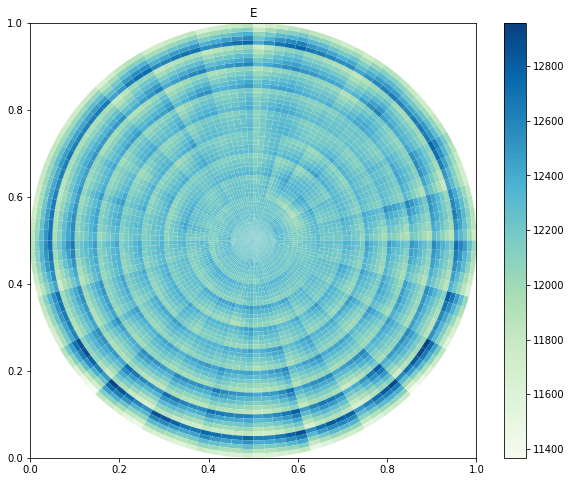

In [367]:
draw_energy_map(W, eM, 
                elims  = None,
                cmap    = matplotlib.cm.GnBu, rmax=180, scale=0.5,
                alpha   = 1.0,  
                figsize=(10,8))

In [368]:
write_energy_map(eM, filename=emap_filename)


In [369]:
eMap = read_energy_map(filename=emap_filename)

In [370]:
eMap

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,12246.675869,12159.143986,12205.245323,12229.456181,12200.743067,12326.563617,12284.201535,12229.093043,12157.292086,12160.389789,...,12281.451927,12193.266660,12077.188509,11981.676343,11884.562170,12424.594779,12312.973943,12176.077554,12000.072527,11771.830209
1,12211.059022,12160.221812,12279.938759,12271.194737,12235.740801,12305.444055,12289.801815,12236.228201,12192.304887,12132.677451,...,12397.994916,12314.798244,12227.797875,12113.474895,11994.856269,12546.913894,12432.675424,12267.995371,12078.721521,11870.858562
2,12172.814328,12266.043729,12243.175538,12246.509302,12242.746027,12301.204618,12295.255855,12210.955978,12199.088158,12136.375231,...,12463.101637,12383.595571,12281.994838,12186.810780,12068.147146,12629.118872,12482.968135,12322.945238,12126.103510,11907.256091
3,12113.265973,12164.537665,12192.226716,12221.508853,12181.164469,12345.431397,12294.646390,12218.828626,12185.502298,12122.430428,...,12508.550237,12400.149651,12290.357484,12173.631584,12062.230012,12593.683290,12449.566746,12286.612309,12093.573998,11866.037067
4,12034.006187,12122.495692,12211.300835,12235.842156,12258.770115,12352.761527,12276.674179,12266.525956,12160.565899,12136.105905,...,12529.009538,12425.895207,12312.759565,12176.470635,12036.398362,12577.616963,12403.365196,12227.810127,12035.059421,11817.379424
5,12186.903969,12245.991858,12192.579683,12215.625058,12219.619873,12401.433556,12324.325500,12259.695947,12176.050469,12131.865720,...,12326.986103,12221.627076,12092.551050,11952.981107,11803.474103,12446.896122,12292.156728,12098.517287,11908.277167,11707.041357
6,12161.007831,12236.313742,12212.288862,12205.080793,12217.035608,12368.507588,12348.063081,12265.656750,12163.037564,12105.815934,...,12434.743438,12308.479748,12185.252482,12027.850479,11872.550432,12522.460573,12327.745125,12127.218178,11930.211387,11712.270594
7,12155.505934,12130.618890,12214.371767,12218.107960,12229.292844,12396.453417,12332.298980,12247.465739,12169.239642,12078.439027,...,12521.393070,12422.442402,12284.887509,12141.707563,11979.386865,12629.396817,12447.053750,12218.428212,12013.633830,11787.366999
8,12078.756564,12178.265124,12214.908423,12242.050460,12235.003721,12394.622469,12323.079364,12229.513142,12121.758165,12080.733609,...,12552.181870,12435.589955,12309.797733,12198.453357,12060.110667,12721.498871,12529.389697,12336.122995,12108.678164,11887.069125
9,12237.611204,12268.583143,12245.812464,12258.180279,12281.499148,12400.251429,12333.676134,12233.803897,12140.106789,12086.737481,...,12528.969777,12438.600783,12334.809691,12209.036098,12102.468019,12768.341207,12610.818125,12404.174797,12198.867786,11986.169560


In [371]:
mu = (eMap.mean()).mean()
mu

12228.166405511194

In [375]:
ns = 50 # number of radial sectors used to compute map
nw = 120 # number of phi sectors used to compute map

fr = Rmax / ns
fphi = 360 / nw
print(f'fr = {fr}, fphi = {fphi}')

fr = 3.6, fphi = 3.0


In [376]:
t0 = time.time()
Ec = e0_correction(E, 
                  dst.R.values, 
                  dst.Phi.values, 
                  CE = eMap / mu,  # normalize to mean
                  fr = fr, 
                  fphi = fphi)
t1 = time.time()
print(f' e0 correction: t = {t1 -t0}')

 e0 correction: t = 30.884634971618652


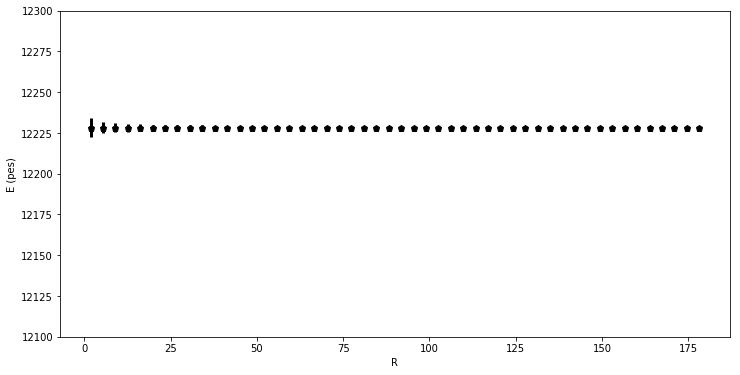

In [382]:
energy_X_profile(kge.R, Ec, xnbins = 50, xrange=(0,180), xlabel = 'R',
                 erange=(12100, 12300),  
                 figsize=(12,6))

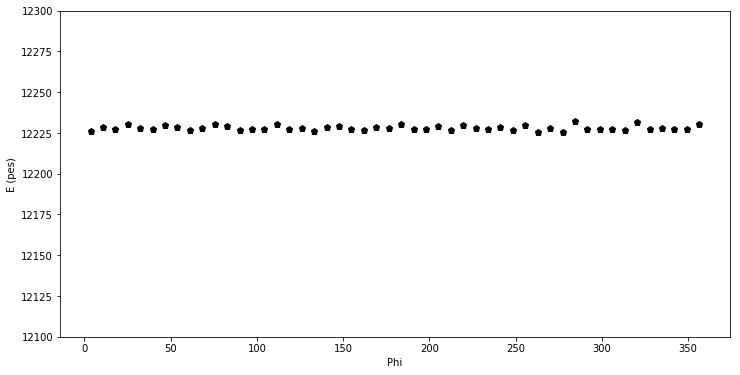

In [383]:
energy_X_profile(phirad_to_deg(kge.Phi), Ec, xnbins = 50, xrange=(0,360), 
                 xlabel = 'Phi',
                 erange=(12100, 12300),  
                 figsize=(12,6))

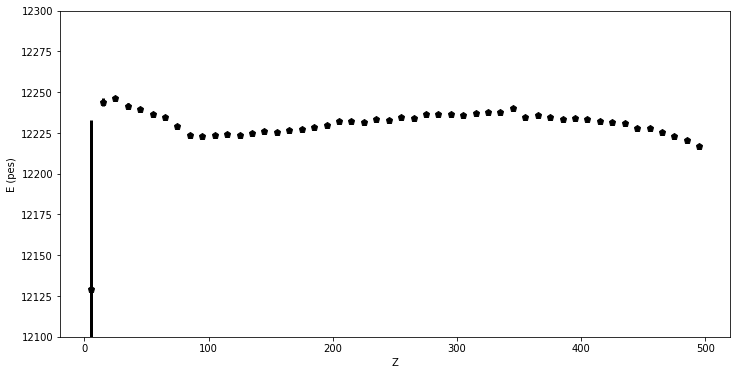

In [384]:
energy_X_profile(kge.Z, Ec, xnbins = 50, xrange=(0,500), xlabel = 'Z',
                 erange=(12100, 12300),   
                 figsize=(12,6))

### R and Phi distributions fixed, Z showing residual effects

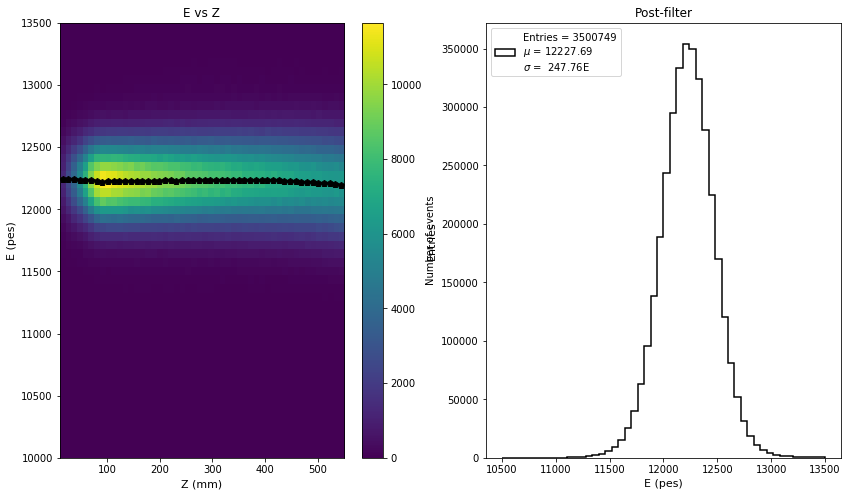

In [385]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

nevt = h2(dst.Z, Ec, krNbins.Z, krNbins.S2e, krRanges.Z, (10000, 13500), profile=True)
plot_histo(PlotLabels(x='Z (mm)', y='E (pes)', title='E vs Z'), ax, legend=False)

ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(Ec,  bins = 50, range =(10500,13500), stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','Post-filter'), ax, legendloc='upper left')

  Fit was valid = True
 Emu       = 12227.876002478904 +-0.130022793668137 
 E sigma   = 238.34088933348661 +-0.100536012883561 
 chi2    = 8.070331527717842 
 sigma E/E (FWHM)     (%) =4.58052641211071
 sigma E/E (FWHM) Qbb (%) =0.5915839472098081 


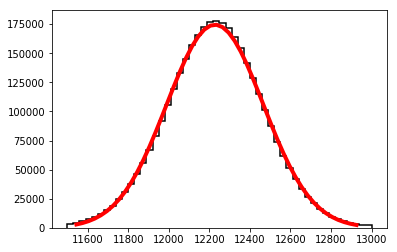

In [386]:
fc = fit_energy(Ec, nbins=50, range=(11500, 13000))
plot_fit_energy(fc)
print_fit_energy(fc)

### Time correction

(12100, 12300)

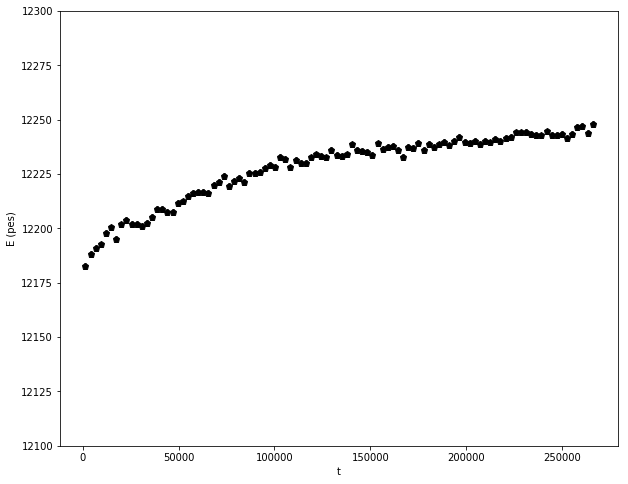

In [387]:
T   =(kge.T - kge.T.min()) 
t, e, eu = fitf.profileX(T, Ec, 100)
erange =(12100, 12300)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1)
plt.errorbar(t, e, eu, fmt="kp", ms=7, lw=3)
plt.xlabel('t')
plt.ylabel('E (pes)')
plt.ylim(erange)

In [388]:
e_mu    = np.nanmean(Ec)
print(e_mu)
e_std   = np.nanstd (Ec)
print(e_std)

12228.1664055112
249.17416342798379


In [389]:
ET_correction = corrf.Correction((t,), e, eu,
                                 norm_strategy =  "const",
                                 norm_opts     = {"value": e_mu})
Ek  = Ec * ET_correction(T).value

(12100, 12300)

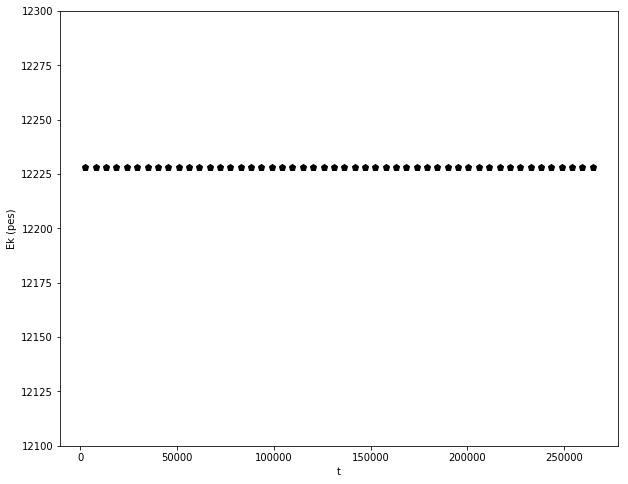

In [391]:
tc, ec, euc = fitf.profileX(T, Ek, 50)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1)
plt.errorbar(tc, ec, euc, fmt="kp", ms=7, lw=3)
plt.xlabel('t')
plt.ylabel('Ek (pes)')
plt.ylim(erange)

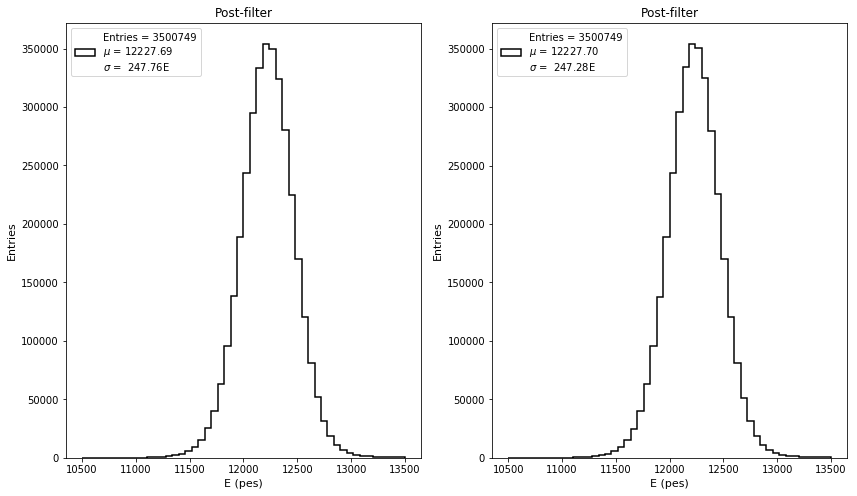

In [394]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

(_)     = h1(Ec,  bins = 50, range =(10500,13500), stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','Post-filter'), ax, legendloc='upper left')
ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(Ek,  bins = 50, range =(10500,13500), stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','Post-filter'), ax, legendloc='upper left')

  Fit was valid = True
 Emu       = 12227.875119902972 +-0.12973930241649517 
 E sigma   = 237.88636157930634 +-0.10023117252305837 
 chi2    = 8.042602996309828 
 sigma E/E (FWHM)     (%) =4.571791453786173
 sigma E/E (FWHM) Qbb (%) =0.5904558102536102 


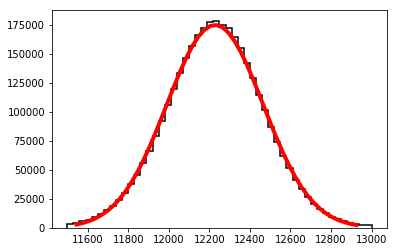

In [395]:
fc = fit_energy(Ek, nbins=50, range=(11500, 13000))
plot_fit_energy(fc)
print_fit_energy(fc)

### As a function of R and Z

In [398]:
Ri = (50,100,150,180)
Zi = range(50,600,50)

FWHM = resolution_r_z(Ri, Zi, kge.R, kge.Z, Ek)

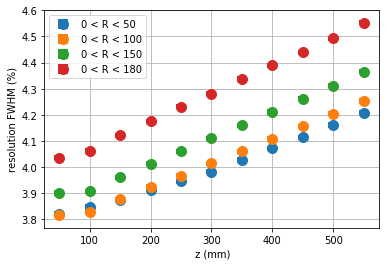

In [400]:
plot_resolution_r_z(Ri, Zi, FWHM)


### Is it possible to reduce the dependence in Z with time-dependent fits?